In [ ]:
import tensorflow as tf
import os
import keras
import cv2
import opendatasets as od
import matplotlib.pyplot as plt
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.models import Model
from keras.layers import Flatten, Dense, LSTM, Dropout, Embedding, Activation
from keras.layers import concatenate, BatchNormalization, Input
from keras.layers import Concatenate
from keras.utils import to_categorical, plot_model
from keras.applications.inception_v3 import InceptionV3, preprocess_input

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
cap_path = "flickr8k/captions.csv"

data = pd.read_csv(cap_path)
data.head()


,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


A child in a pink dress is climbing up a set of stairs in an entry way .
A girl going into a wooden building .
A little girl climbing into a wooden playhouse .
A little girl climbing the stairs to her playhouse .
A little girl in a pink dress going into a wooden cabin .


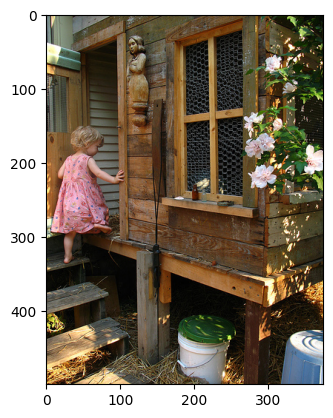

In [16]:
img_path = 'flickr8k\Images'
def visualizaion(img_name):
  cap = data.loc[data['image'] == img_name]
  img = plt.imread(img_path + '/' + img_name)
  plt.imshow(img)
  for c in cap['caption']:
    print(c)
visualizaion('1000268201_693b08cb0e.jpg')


In [17]:
data['caption'] = data['caption'].apply(lambda x: x.lower())
data['caption'] = data['caption'].apply(lambda x: x.replace("[^A-Za-z]",""))
data['caption'] = data['caption'].apply(lambda x: x.replace("\s+"," "))
data['caption'] = data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1]))
data['caption'] = 'startseq ' + data['caption'] + ' endseq'
data['caption'].head()

0    startseq child in pink dress is climbing up se...
1      startseq girl going into wooden building endseq
2    startseq little girl climbing into wooden play...
3    startseq little girl climbing the stairs to he...
4    startseq little girl in pink dress going into ...
Name: caption, dtype: object

In [18]:
captions = data['caption'].tolist()
captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [21]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)

images = data['image'].unique().tolist()
nimages = len(images)

split_index = round(0.85*nimages)
train_images = images[:split_index]
val_images = images[split_index:]

train = data[data['image'].isin(train_images)]
test = data[data['image'].isin(val_images)]

train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)

tokenizer.texts_to_sequences([captions[1]])[0]

[1, 18, 315, 63, 195, 116, 2]

In [24]:
import tqdm
from keras.preprocessing.image import load_img, img_to_array
import numpy as np
model = InceptionV3(weights='imagenet')
fe = Model(inputs=model.input, outputs=model.layers[-2].output)

img_size = 299
features = {}
for image in tqdm.tqdm(data['image'].unique().tolist()):
    img = load_img(os.path.join(img_path, image), target_size=(img_size, img_size))
    img = img_to_array(img)
    img = img / 255.
    img = np.expand_dims(img, axis=0)
    feature = fe.predict(img, verbose=0)
    features[image] = feature

100%|██████████| 8091/8091 [17:36<00:00,  7.66it/s]


In [25]:
import pickle
with open('features.pkl', 'wb') as file: 
      
    # A new file will be created 
    pickle.dump(features, file) 

In [32]:
from tensorflow.keras.utils import Sequence
class CustomDataGenerator(Sequence):
    
    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer, 
                 vocab_size, max_length, features,shuffle=True):
    
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)
        
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    def __len__(self):
        return self.n // self.batch_size
    
    def __getitem__(self,index):
    
        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X1, X2, y = self.__get_data(batch)        
        return (X1, X2), y
    
    def __get_data(self,batch):
        
        X1, X2, y = list(), list(), list()
        
        images = batch[self.X_col].tolist()
           
        for image in images:
            feature = self.features[image][0]
            
            captions = batch.loc[batch[self.X_col]==image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)
            
        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                
        return X1, X2, y

In [ ]:
from tensorflow.keras.layers import  add, Reshape, concatenate
input1 = Input(shape=(2048,))
input2 = Input(shape=(max_length,))

img_features = Dense(256, activation='relu')(input1)
img_features_reshaped = Reshape((1, 256), input_shape=(256,))(img_features)

sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)
merged = concatenate([img_features_reshaped,sentence_features],axis=1)
sentence_features = LSTM(256)(merged)
x = Dropout(0.5)(sentence_features)
x = add([x, img_features])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x)

caption_model = Model(inputs=[input1,input2], outputs=output)
caption_model.compile(loss='categorical_crossentropy',optimizer='adam')

In [40]:
caption_model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 256)       │    524,544 │ input_layer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_7       │ (None, 34)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 1, 256)    │          0 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 34, 256)   │  2,172,160 │ input_layer_7[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_6       │ (None, 35, 256)   │          0 │ reshape_2[0][0],  │
│ (Concatenate)       │                   │            │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 256)       │    525,312 │ concatenate_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 256)       │          0 │ lstm_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 256)       │          0 │ dropout_4[0][0],  │
│                     │                   │            │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 128)       │     32,896 │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 128)       │          0 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 8485)      │  1,094,565 │ dropout_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,349,477 (16.59 MB)

 Trainable params: 4,349,477 (16.59 MB)

 Non-trainable params: 0 (0.00 B)

In [41]:
train_generator = CustomDataGenerator(df=train,X_col='image',y_col='caption',batch_size=64,directory=img_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

validation_generator = CustomDataGenerator(df=test,X_col='image',y_col='caption',batch_size=64,directory=img_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)


In [42]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
model_name = "model.h5"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.00000001)

In [71]:
history = caption_model.fit(
        train_generator,
        epochs=50,
        validation_data=validation_generator,
        callbacks=[checkpoint,earlystopping,learning_rate_reduction])

Epoch 1/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step - loss: 3.1688
Epoch 1: val_loss did not improve from 3.61155
537/537 ━━━━━━━━━━━━━━━━━━━━ 287s 533ms/step - loss: 3.1688 - val_loss: 3.6337 - learning_rate: 2.0000e-04
Epoch 2/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step - loss: 3.1270
Epoch 2: val_loss did not improve from 3.61155
537/537 ━━━━━━━━━━━━━━━━━━━━ 274s 509ms/step - loss: 3.1270 - val_loss: 3.6355 - learning_rate: 2.0000e-04
Epoch 3/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step - loss: 3.1195
Epoch 3: val_loss did not improve from 3.61155
537/537 ━━━━━━━━━━━━━━━━━━━━ 267s 497ms/step - loss: 3.1195 - val_loss: 3.6481 - learning_rate: 2.0000e-04
Epoch 4/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step - loss: 3.1080
Epoch 4: val_loss did not improve from 3.61155

Epoch 4: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
537/537 ━━━━━━━━━━━━━━━━━━━━ 266s 495ms/step - loss: 3.1080 - val_loss: 3.6618 - learning_rate: 2.0000e-04
Epoch 5/50
537/537 ━━━━━━━━━━━

In [44]:
def idx_to_word(integer,tokenizer):
    
    for word, index in tokenizer.word_index.items():
        if index==integer:
            return word
    return None

In [65]:
def predict_caption(model, image, tokenizer):
    feature = fe.predict(image, verbose=0)
    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)

        y_pred = model.predict([feature, sequence])
        y_pred = np.argmax(y_pred)
        
        word = idx_to_word(y_pred, tokenizer)
        
        if word is None:
            break
            
        in_text += " " + word
        
        if word == 'endseq':
            break
            
    return in_text[8:-6]



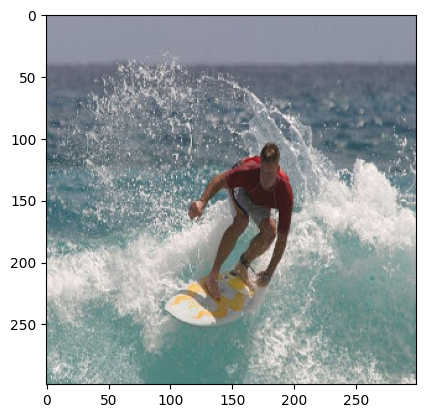

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
 surfer is surfing 


In [66]:
img = cv2.imread('surf.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
img = cv2.resize(img, (299, 299))
img = img / 255.0  
plt.imshow(img)
plt.show()


img = np.expand_dims(img, axis=0)


caption = predict_caption(caption_model, img, tokenizer)
print(caption)

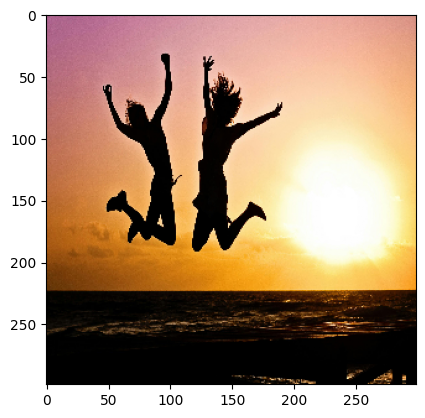

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
 man is jumping on the beach 


In [70]:
img = cv2.imread('youth-active-jump-happy-40815.jpeg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
img = cv2.resize(img, (299, 299))
img = img / 255.0  
plt.imshow(img)
plt.show()


img = np.expand_dims(img, axis=0)


caption = predict_caption(caption_model, img, tokenizer)
print(caption)